# 第3章

In [1]:
import codecs

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split

from mf import MatrixFactorization

## Yahoo! R3データの読み込みと前処理

In [2]:
# オリジナルのトレーニングデータを読み込む
with codecs.open("./data/train.txt", "r", "utf-8") as f:
    train = pd.read_csv(f, delimiter="\t", header=None).values
    train[:, 0], train[:, 1] = train[:, 0] - 1, train[:, 1] - 1

# オリジナルのテストデータを読み込む
with codecs.open("./data/test.txt", "r", "utf-8") as f:
    test = pd.read_csv(f, delimiter="\t", header=None).values
    test[:, 0], test[:, 1] = test[:, 0] - 1, test[:, 1] - 1

# トレーニングデータのうち, 30%を無作為にバリデーションデータとする
train, val = train_test_split(train, test_size=0.30, random_state=12345)
# テストデータのうち, 1%を無作為に抽出し傾向スコアの推定に用いる
random, test = train_test_split(test, test_size=0.99, random_state=12345)

# 少量の完全ランダムな嗜好度合いデータを用いて傾向スコアを推定する [Schnabel16]
numerator = np.unique(train[:, 2], return_counts=True)[1]
numerator = numerator / numerator.sum() # P(R=r | O=1)の推定
denominator = np.unique(random[:, 2], return_counts=True)[1]
denominator = denominator / denominator.sum()  # P(R=r)の推定
pscore = numerator / denominator

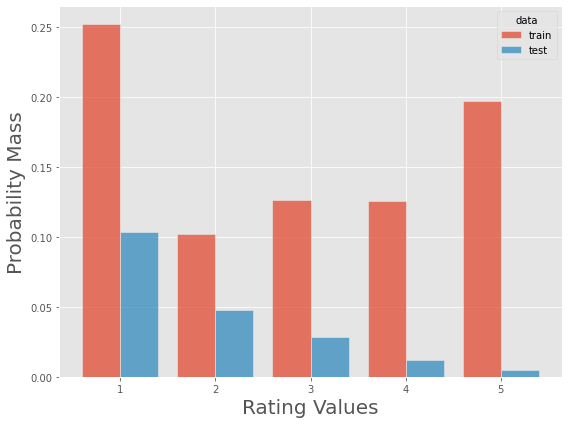

In [3]:
# 図3.11で確認した通り、トレーニングデータとテストデータのレーティング分布は大きく乖離している
plt.subplots(1, figsize=(8,6))
train_df = DataFrame(train)
train_df["data"] = "train"
test_df = DataFrame(test)
test_df["data"] = "test"
data_df = pd.concat([train_df, test_df])
data_df.rename(columns={0: "user_id", 1: "item_id", 2: "rating"}, inplace=True)
sns.histplot(data_df, x="rating", hue="data", stat="probability", discrete=True, multiple="dodge", shrink=.8)
   
plt.xlabel("Rating Values", fontdict=dict(size=20))
plt.ylabel("Probability Mass", fontdict=dict(size=20))
plt.tight_layout()
plt.show()

## ナイーブ推定量に基づくMatrix Factorizationの学習

In [4]:
mf_naive = MatrixFactorization(
    k=10,
    learning_rate=0.0001,
    reg_param=0.0001,
    random_state=12345,
)
val_loss_naive, test_loss_naive = mf_naive.fit(
    train=train, val=val, test=test, n_epochs=100
)

100%|██████████| 100/100 [13:27<00:00,  8.08s/it]


## IPS推定量に基づくMatrix Factorizationの学習

In [5]:
mf_ips = MatrixFactorization(
    k=10,
    learning_rate=0.0001,
    reg_param=0.0001,
    random_state=12345,
)
val_loss_ips, test_loss_ips = mf_ips.fit(
    train=train, val=val, test=test, pscore=pscore, n_epochs=100
)

100%|██████████| 100/100 [13:04<00:00,  7.85s/it]


## 学習曲線の描画

### ナイーブ推定量に基づくMatrix Factorizationのバリデーションデータに対する誤差とテストデータに対する誤差の比較

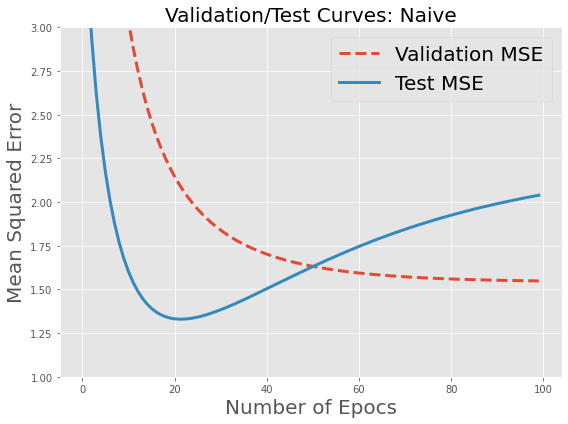

In [6]:
plt.subplots(1, figsize=(8,6))
plt.plot(np.arange(len(val_loss_naive)), val_loss_naive, label="Validation MSE", linewidth=3, linestyle="dashed")
plt.plot(np.arange(len(test_loss_naive)), test_loss_naive, label="Test MSE", linewidth=3)
   
plt.title("Validation/Test Curves: Naive", fontdict=dict(size=20))
plt.xlabel("Number of Epocs", fontdict=dict(size=20))
plt.ylabel("Mean Squared Error", fontdict=dict(size=20))
plt.ylim([1.0, 3.0])
plt.tight_layout()
plt.legend(loc="best", fontsize=20)
plt.show()

### IPS推定量に基づくMatrix Factorizationのバリデーションデータに対する誤差とテストデータに対する誤差の比較

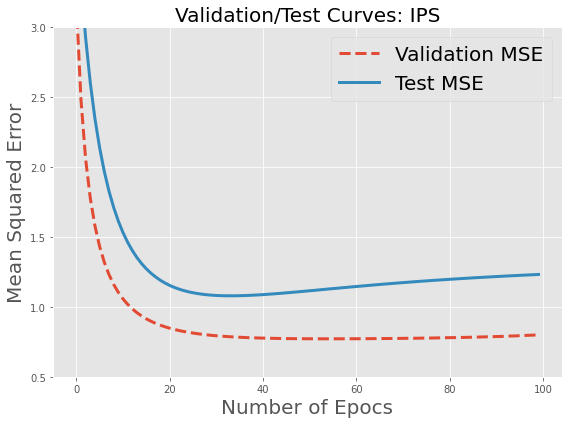

In [7]:
plt.subplots(1, figsize=(8,6))
plt.plot(np.arange(len(val_loss_ips)), val_loss_ips, label="Validation MSE", linewidth=3, linestyle="dashed")
plt.plot(np.arange(len(test_loss_ips)), test_loss_ips, label="Test MSE", linewidth=3)
 
plt.title("Validation/Test Curves: IPS", fontdict=dict(size=20))
plt.xlabel("Number of Epocs", fontdict=dict(size=20))
plt.ylabel("Mean Squared Error", fontdict=dict(size=20))
plt.ylim([0.5, 3.0])
plt.tight_layout()
plt.legend(loc="best", fontsize=20)
plt.show()

### ナイーブ推定量とIPS推定量を用いたときのそれぞれのテストデータに対する誤差の比較

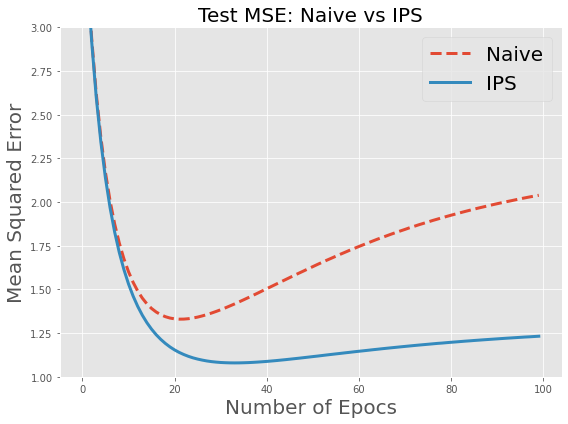

In [8]:
plt.subplots(1, figsize=(8,6))
plt.plot(np.arange(len(test_loss_naive)), test_loss_naive, label="Naive", linewidth=3, linestyle="dashed")
plt.plot(np.arange(len(test_loss_ips)), test_loss_ips, label="IPS", linewidth=3)
   
plt.title("Test MSE: Naive vs IPS", fontdict=dict(size=20))
plt.xlabel("Number of Epocs", fontdict=dict(size=20))
plt.ylabel("Mean Squared Error", fontdict=dict(size=20))
plt.ylim([1.0, 3.0])
plt.tight_layout()
plt.legend(loc="best", fontsize=20)
plt.show()